### Notebook: Regex approach

Use simple/basic regex apprach to extract the metaphors from the Interveiws.

In [256]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('averaged_perceptron_tagger')

import spacy
sp = spacy.load('en_core_web_sm')

tqdm.pandas()

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#ECB Color
color = (17/255, 49/255, 147/255)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Choice between Stemming or Lemmatization:

Stemming: Stemming is generally faster and simpler than lemmatization, but it may not always produce a valid word since it applies simple rules to chop off suffixes. In your case, stemming could potentially match "beat" with "beating" but may produce incorrect results in some cases.

Lemmatization: Lemmatization, on the other hand, maps words to their base or dictionary form, which is more linguistically accurate. It typically requires more computational resources compared to stemming but can provide more accurate results

Select modulation for this notebook:

In [257]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod = 2

In [258]:
# Functions:
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos 
def tokenize(text, modulation):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split text into sentences while preserving periods

    processed_sentences = []

    for sentence in sentences:
        if modulation < 2:
            # Tokenize and preprocess each sentence
            tokens = re.findall(r'\w+', sentence.lower())
            stems = []
            for token in tokens:
                lowers = abbr_or_lower(token)
                if lowers not in stop_words and re.search('[a-zA-Z]', lowers):
                    if modulation == 0:
                        stems.append(lowers)
                    elif modulation == 1:
                        stems.append(porter.stem(lowers))
            processed_sentence = " ".join(stems)
        else:
            doc = sp(sentence)
            lemmatized_tokens = []
            for token in doc:
                if token.text.strip():
                    lemmatized_tokens.append(token.lemma_)
            processed_sentence = " ".join(lemmatized_tokens)

        processed_sentences.append(processed_sentence)

    # Reconstruct the text with preserved sentence boundaries
    processed_text = " ".join(processed_sentences)

    return processed_text



def tokenize_word_list(word_list, modulation):
    processed_words = []

    for word in word_list:
        processed_word = word.lower()
        if modulation < 2:
            if modulation == 0:
                processed_words.append(processed_word)
            elif modulation == 1:
                processed_words.append(porter.stem(processed_word))
        else:
            # Apply lemmatization using spaCy
            doc = sp(word)
            lemmatized_text=[]
            for w_ in doc:
                lemmatized_text.append(w_.lemma_)
            processed_words.extend([abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)])

    return " ".join(processed_words)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_end_answer(text):
    text = text.replace(r'[end_answer]', '')
    return text

def remove_special_characters_keep_point(text):
    # Define the regex pattern to match special characters except "."
    pattern = r"[^\w\s\.\']"
    # Replace special characters with an empty string
    text = re.sub(pattern, '', text)
    # Replace consecutive dots with just one dot
    text = re.sub(r'\.{2,}', '.', text)
    return text

def remove_unnecessary_spaces(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_starting_month(text):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pattern = r'^(' + '|'.join(months) + r')\s'
    text = re.sub(pattern, '', text)
    return text

def regex_matcher(text, as_words):
    # Split text into sentences using period as delimiter
    sentences = re.split(r'\.\s*', text)

    selected_sentences = []

    for sentence in sentences:
        # Check if the sentence contains "inflation" and any word from as_words
        if "inflation" in sentence.lower() and any(word in sentence.lower() for word in as_words):
            selected_sentences.append(sentence)

    return selected_sentences

def regex_matcher_word_order(text, as_words):
    # Split text into sentences using period as delimiter
    sentences = re.split(r'\.\s*', text)

    selected_sentences = []

    for sentence in sentences:
        # Check if the sentence contains "inflation" and any word from as_words
        sentence_lower = sentence.lower()
        if any(word in sentence_lower for word in as_words) and "inflation" in sentence_lower:
            # Split the sentence into words
            words = sentence_lower.split()
            # Check if any word from as_words appears before "inflation"
            if any(word in as_words for word in words[:words.index("inflation")]):
                selected_sentences.append(sentence)

    return selected_sentences

def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

def text_length_distribution(df):
    df['text_length'] = df['Answers'].apply(len)
    plt.figure(dpi=300)
    # Plot histogram with a label for the legend
    df['text_length'].hist(bins=30, color=color, label='Text Length')
    # Add title and labels
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

In [259]:
# Import dataset containing the interveiw data
df = pd.read_csv('data_complete.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# For computation speed, limit the data to the last 30 rows:
df = df.tail(30)

df.head()

,Date,Media,Member,Link,Information,Questions,Answers
489,2023-06-02,Interview with Le Monde,Fabio Panetta,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Fabio Panetta, Member of the Ex...",The ECB’s objective is to keep inflation at 2%...,2 June 2023[end_answer] There is no doubt that...
490,2023-05-24,Interview with Les Echos,Fabio Panetta,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Fabio Panetta, Member of the Ex...",As the ECB celebrates its 25th anniversary tod...,24 May 2023[end_answer] We are studying the de...
491,2023-05-14,Interview with Il Sole 24 Ore,Luis de Guindos,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Luis de Guindos, Vice-President...","With seven hikes in one year, the ECB has rais...",14 May 2023[end_answer] Our mandate is price s...
492,2023-05-10,Interview with Nikkei,Christine Lagarde,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Christine Lagarde, President of...",You repeatedly mentioned at the last press con...,10 May 2023[end_answer] There are factors that...
493,2023-04-25,Interview with Le Monde,Philip R. Lane,https://www.ecb.europa.eu/press/inter/date/202...,"Interview with Philip R. Lane, Member of the E...","Last autumn, a euro area recession at the begi...","25 April 2023[end_answer] Yes, the indicators ..."


In [260]:
# We won't need the Questions, Link column for this analysis
df = df.drop(columns=['Questions', 'Link'])
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (30, 5)


Date           0
Media          0
Member         0
Information    0
Answers        0
dtype: int64

In [261]:
# Drop the rows with missing values
df = df.dropna()
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (30, 5)


Date           30
Media          26
Member          6
Information    30
Answers        30
dtype: int64

In [262]:
#types of data
df.dtypes

Date           datetime64[ns]
Media                  object
Member                 object
Information            object
Answers                object
dtype: object

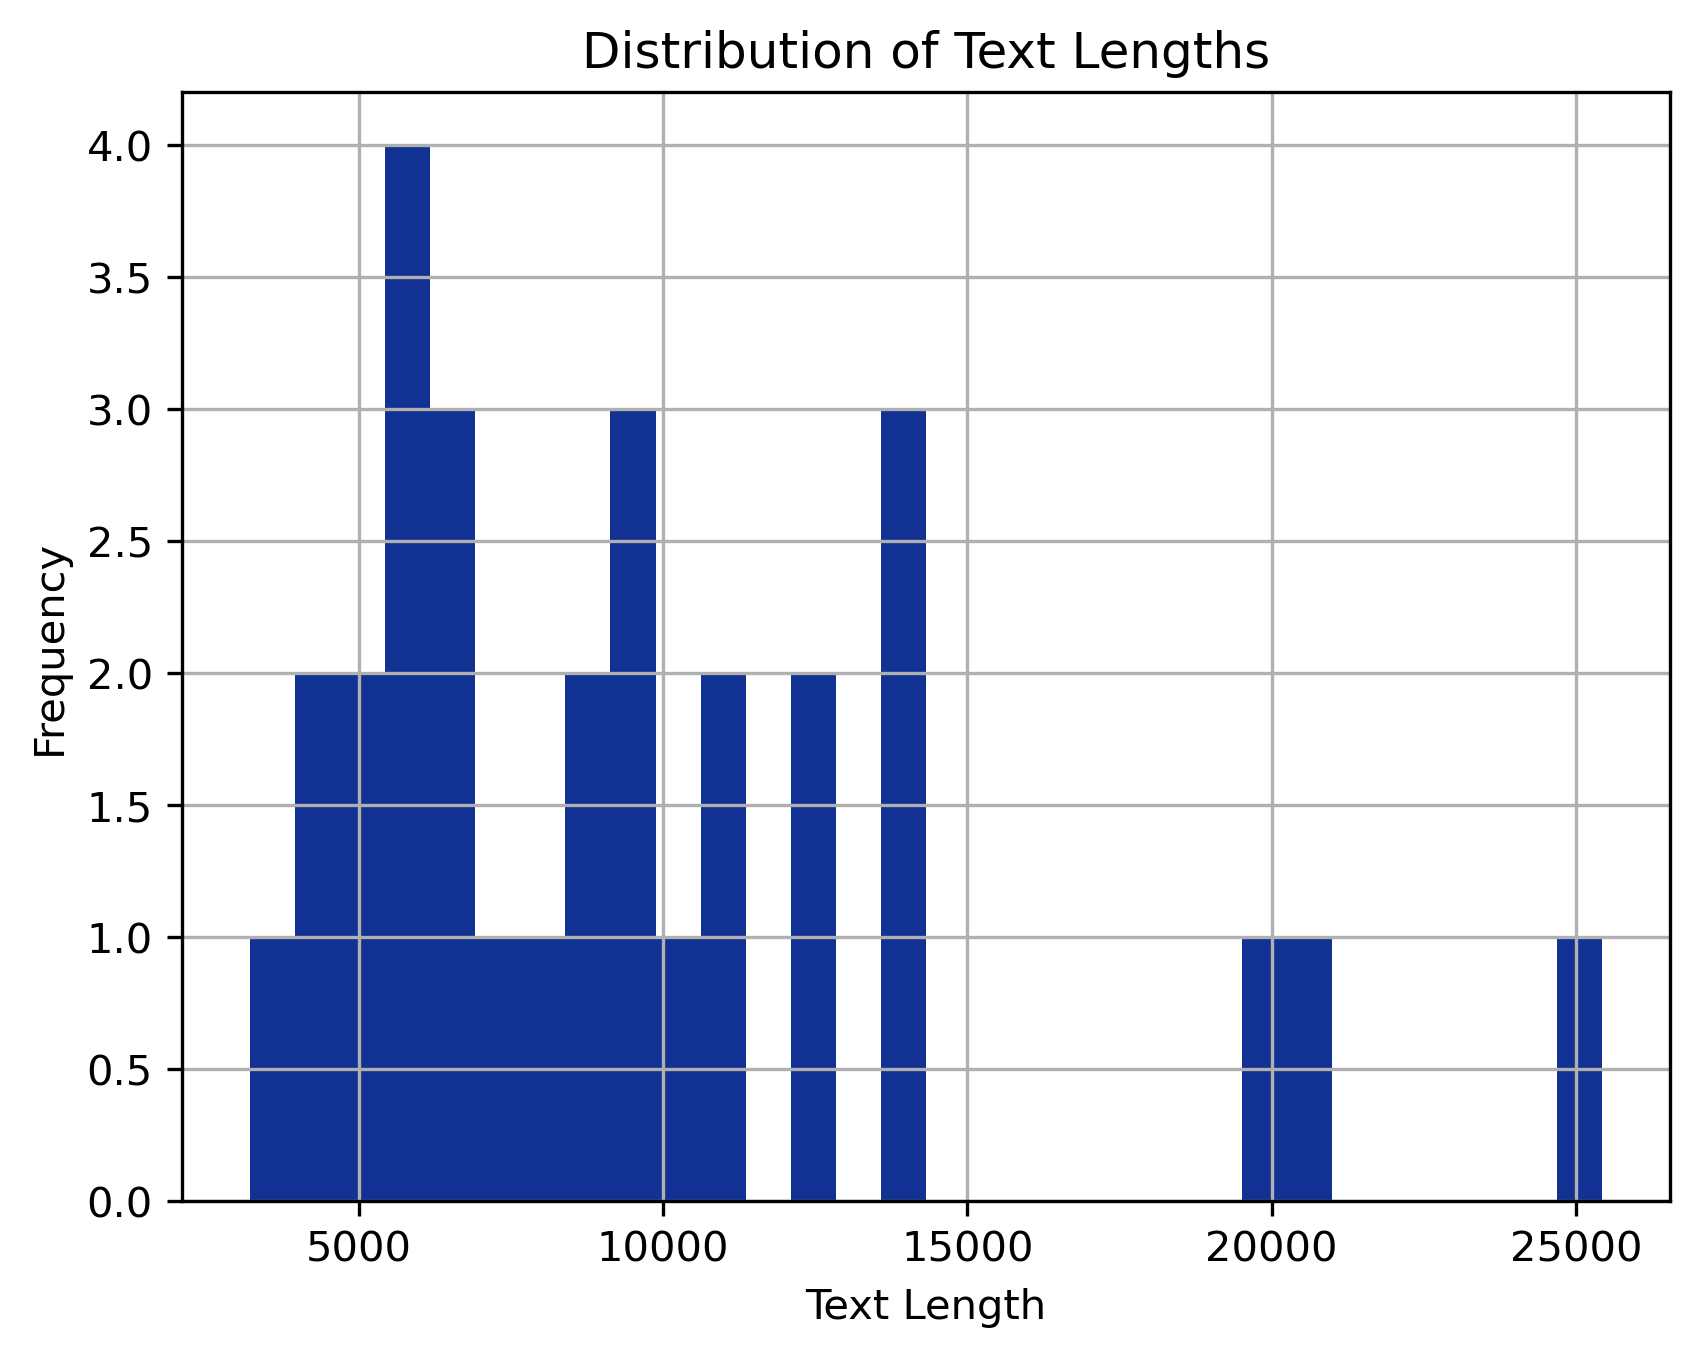

The mean length is:  9680.0


In [263]:
text_length_distribution(df)
# average text length
print("The mean length is: ",df['text_length'].mean())


In [264]:
# List of words to match: (taken from paper: Inflation Metaphor in Contemporary American English)
as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff']
as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy']
as_plant = ['hedge','nip']
as_animal = ['soar', 'runaway', 'rampant', 'curb', 'tame', 'rein', 'spur', 'creep', 'whip', 'gallop', 'halt', 'roar', 'hover', 'curtail', 'spawn', 'gnaw', 'hibernation']
as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically']
as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset']
as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake']
as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom']
as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'downward', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing']

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation

print("Length of the list of words to match: ", len(as_words))

Length of the list of words to match:  115


In [265]:
# Pre-process the list of words with the same modulation as the interviews
as_words = tokenize_word_list(as_words, mod)
as_words

'ignite fuel spark dampen stoke kindle choke stifle fan flare douse snuff erode surge subside simmer emergence ebb dilute spurt recede buoy hedge nip soar runaway rampant curb tame rein spur creep whip gallop halt roar hover curtail spawn gnaw hibernation plague worsen benign virulent debilitate bout chronically threat subdue target beat preempt vigilant ravage undermine forestall counteract eliminate ferocious ruinous clobber buster eradicate besiege thwart bash beset pace outstrip lag surpass quicken outrun bout good tug war zip overtake accelerate fast control slow trigger skyrocket rapid heat escalate decelerate ratchet unchecked readjust chug damper zoom low rise high increase reduce decline fall exceed spiral hyper upward uptick downward boost peak diminish upturn hike plummet upswe'

In [266]:
def preprocess_text(df):
        text_preproc = (
                df.Answers
                .astype(str)
                .progress_apply(lambda row: remove_end_answer(row))
                .progress_apply(lambda row: remove_numbers(row))
                .progress_apply(lambda row: remove_special_characters_keep_point(row))
                .progress_apply(lambda row: remove_unnecessary_spaces(row))
                .progress_apply(lambda row: remove_starting_month(row))
                .progress_apply(lambda row: tokenize(row, mod)))

        df["Answers_cleaned"]=text_preproc

        return df

df = preprocess_text(df)

100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


In [267]:
# This adds the list of sentences containing the words to match in a new column
regex_match = (df.Answers_cleaned.apply(lambda x: regex_matcher(x, as_words)))
df["list_regex"] = regex_match

In [268]:
# Check results of the regex matching:
df["list_regex"].iloc[0]

['we will bring inflation back to ',
 'and inflation be fall as confirm by yesterdays datum ',
 'it take several quarter before its effect be fully feel by the real economy and then transmit to inflation ',
 'our March projection suggest that inflation should hover around early next year and approach in ',
 'investor understand that inflation have rise because of a series of adverse global shock that be beyond the control of monetary policy ',
 'they know that we will intervene until we see inflation head convincingly towards our target and they expect it to return to that level ',
 'so far we have not succeed but not because of the reason suggest by commentator in who predict a sharp rise in inflation ',
 'without these unpredictable event the economic landscape would be quite different with significantly low inflation ',
 'inflation be largely cause by bottleneck and the war not monetary policy ',
 'we be now address the inflationary consequence of these shock and our action should b

<Axes: >

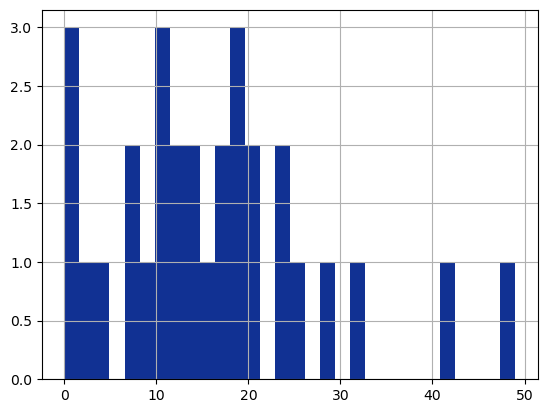

In [269]:
# Histogram of the length of list in list_regex:
df["list_regex"].apply(len).hist(bins=30, color=color, label='Number of Sentences matching')

In [270]:
# Save the dataframe
# df.to_csv("data_test.csv", index=False)